# A405 final problem

The cells below read in pres (hPa), hght (m), temp (C), dwpt (C) stored as a dataframe
in final_sounding.h5 dataframe 

For each question, insert a cell or cells that answers the question.  You are free to use any code in the github master branch, but double check before you hand in your notebook that it runs on a clean checkout of the
master branch (i.e. that you've included all your own code).

Hand in via email  (which may not work if the attachment is too big), or by sharing a dropbox-like url.

Due on Wednesday, April 20 at 9am.

Good luck, and don't hesitate to ask if anything is unclear.


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import h5py
import soundings
from pathlib import Path
from a405thermo.thermlib import find_thetaet, find_rsat, tinvert_thetae
from a405thermo.constants import constants as c
site = 'final_sounding.h5'
sounding_file = str(Path(soundings.__path__[0]) / site)
with pd.HDFStore(sounding_file) as store:
    for key in store:
        df_sounding=store[key]
print(df_sounding.head())

    pres   hght  temp  dwpt
0  991.0  172.0  23.2  19.2
1  988.0  198.0  22.8  18.8
2  941.6  610.0  19.0  15.0
3  925.0  762.0  17.6  13.6
4  908.5  914.0  16.3  13.3


# Problem 1

make a 2 column  plot of the temperature and dewpoint as a function height for
the bottom 8000 meters of the sounding

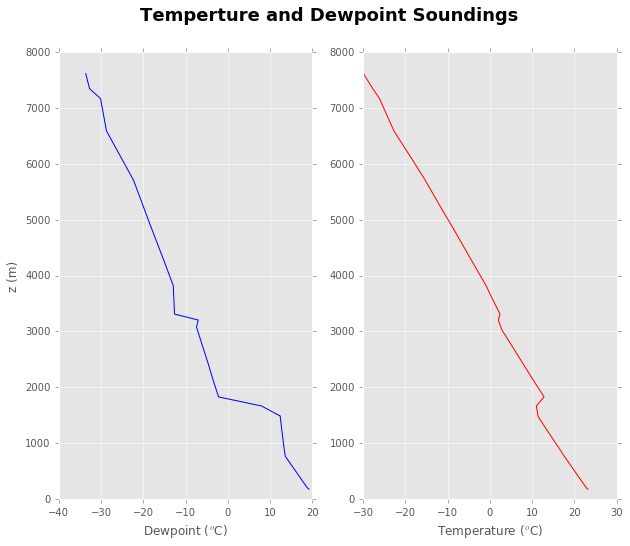

In [2]:
%matplotlib inline
plt.style.use("ggplot")

# make copy of df for heights less than 8000 m, so only need to perform logical indexing once
top_hght = 8000 # m
df_bottom = df_sounding[df_sounding["hght"] < top_hght]

# plot temperature and dewpoint soundings 
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,8))
ax1.plot(df_bottom["dwpt"], df_bottom["hght"], "-b")
ax2.plot(df_bottom["temp"], df_bottom["hght"], "-r")
ax1.set_xlabel(r"Dewpoint ($^o$C)")
ax2.set_xlabel(r"Temperature ($^o$C)")
ax1.set_ylabel("z (m)")
fig.suptitle("Temperture and Dewpoint Soundings", fontsize=18, fontweight="bold")

# Problem 2

redraw your problem 1 figure, adding the moist adiabat for the lowest point (172 meters) 

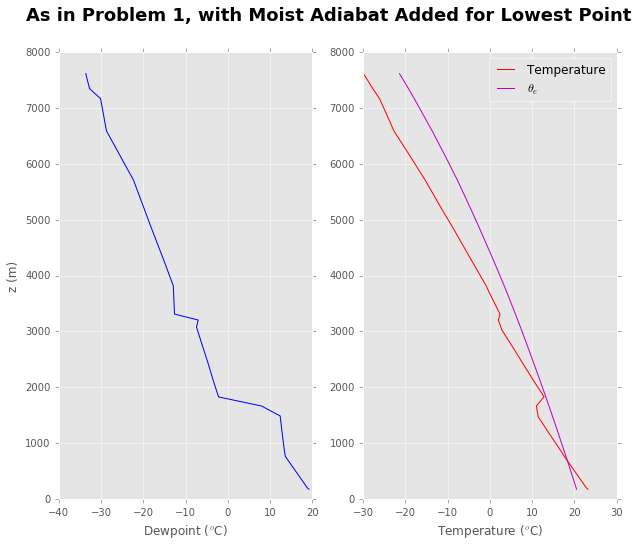

In [3]:
from a405thermo.thermlib import find_Tmoist

# calculate thetae of bottom point
parc_td = df_bottom["dwpt"][0] + c.Tc # K
parc_temp = df_bottom["temp"][0] + c.Tc # K
parc_pres = df_bottom["pres"][0]*100. # Pa

rt = find_rsat(parc_td, parc_pres) # kg/kg
thetae = find_thetaet(parc_td, rt, parc_temp, parc_pres) # K

# calculate temperatures along moist adiabat

moist_temps = []
for pres in df_bottom["pres"]:
    #temps, rv, rl = tinvert_thetae(thetae, rt, pres*100)
    temps = find_Tmoist(thetae, pres*100)
    moist_temps.append(temps - c.Tc)

# replot temperature and dewpoint soundings, with moist adiabat
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,8))
ax1.plot(df_bottom["dwpt"], df_bottom["hght"], "-b")
ax2.plot(df_bottom["temp"], df_bottom["hght"], "-r", label="Temperature")
ax2.plot(moist_temps, df_bottom["hght"], "-m", label=r"$\theta_e$")
ax1.set_xlabel(r"Dewpoint ($^o$C)")
ax2.set_xlabel(r"Temperature ($^o$C)")
ax2.legend(loc="upper right")
ax1.set_ylabel("z (m)")
fig.suptitle("As in Problem 1, with Moist Adiabat Added for Lowest Point", fontsize=18, fontweight="bold")

# Problem 3

Write a function that takes as input the dataframe and a height, and finds rv, rl and the buoyancy at that
height.   Use it to calculate rv, rl and the buoyancy for air from 172 meters lifted to 4 km.


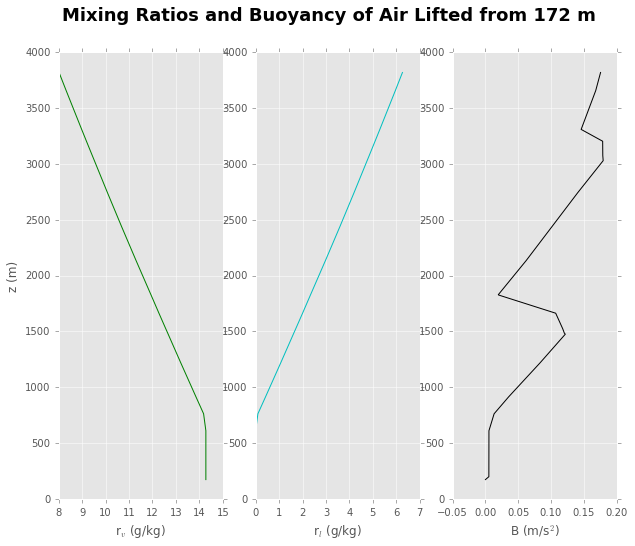

In [10]:
def calc_buoy(df_sounding, height, check_height=False):
    """Calculates the buoyancy, and vapor and liquid mixing ratios of a parcel from a dataframe
    
    Inputs:
        df_sounding (dataframe) - dataframe of sounding, with columns "pres" [hPa], "hght" [m], "temp" [oC], "dwpt" [oC]
        height (float) - altitude of parcel [m]
        check_height (boolean) - optional, decide whether or not to output sounding height, default is False
        
    Outputs:
        rv (float) - vapour mixing ratio [kg/kg] at that altitude
        rl (float) - liquid mixing ratio [kg/kg] at that altitude
        buoy (float) - buoyancy of the parcel [m/s^2] at that altitude
    """
    
    # find closest hght in df to height
    parcel_ind = df_sounding.ix[(df_sounding['hght']-height).abs().argsort()[:1]].index[0]
    if check_height:
        print("Closest height to {} m is {} m in the sounding".format(height, df_sounding["hght"][parcel_ind]))
    
    # calculate thetae of bottom point
    bot_td = df_sounding["dwpt"][0] + c.Tc # K
    bot_temp = df_sounding["temp"][0] + c.Tc # K
    bot_pres = df_sounding["pres"][0]*100. # Pa

    rt = find_rsat(bot_td, bot_pres) # kg/kg
    thetae = find_thetaet(bot_td, rt, bot_temp, bot_pres) # K
    
    # find temp, rv and rl at input height
    temp, rv, rl = tinvert_thetae(thetae, rt, df_sounding["pres"][parcel_ind]*100)
    
    # calculate virtual temperatures
    Tv_parc = temp*(1 + c.eps*rv - rl)
    Tv_env = (df_sounding["temp"][parcel_ind] + c.Tc)*(1 + c.eps*rv - rl)

    # calculate buoyancy
    buoy = c.g0*((Tv_parc - Tv_env)/Tv_env)
    
    return(rv, rl, buoy)


top_height = 4000 # m    
heights = df_sounding["hght"][df_sounding["hght"] < top_height]

# compute rv, rl and buoy at each height
rvs = []
rls = []
buoys = []

for each_height in heights:
    rv, rl, buoy = calc_buoy(df_sounding, each_height)
    rvs.append(rv*1000) # g/kg
    rls.append(rl*1000) # g/kg
    buoys.append(buoy) # m/s^2
    
# plot rv, rl and buoy soundings
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,8))
ax1.plot(rvs, heights, "-g")
ax2.plot(rls, heights, "-c")
ax3.plot(buoys, heights, "-k")


ax1.set_xlabel(r"r$_v$ (g/kg)")
ax2.set_xlabel(r"r$_l$ (g/kg)")
ax3.set_xlabel(r"B (m/s$^2$)")

ax1.set_ylabel("z (m)")
fig.suptitle("Mixing Ratios and Buoyancy of Air Lifted from 172 m", fontsize=18, fontweight="bold")

# Problem 4

Calculate and make a plot of the virtual temperature of mixtures of adiabatic air from 172 meters and environmental air at 4 km.
Use 20 mixtures evenly spaced between (100% cloud, 0% environment) and (0 %cloud, 100% environment).
Plot the mixing fraction on the x axis and the virtual temperature on the y axis.